In [3]:
# -*- coding: utf-8 -*-
#!/usr/bin/python

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [6]:
data = {'nomi':['A','B','C','D','E','F'], 'tempi':[12,34,11,6,79,3], 'occorrenze':[3,1,3,4,5,2]}
DF =  pd.DataFrame.from_dict(data)

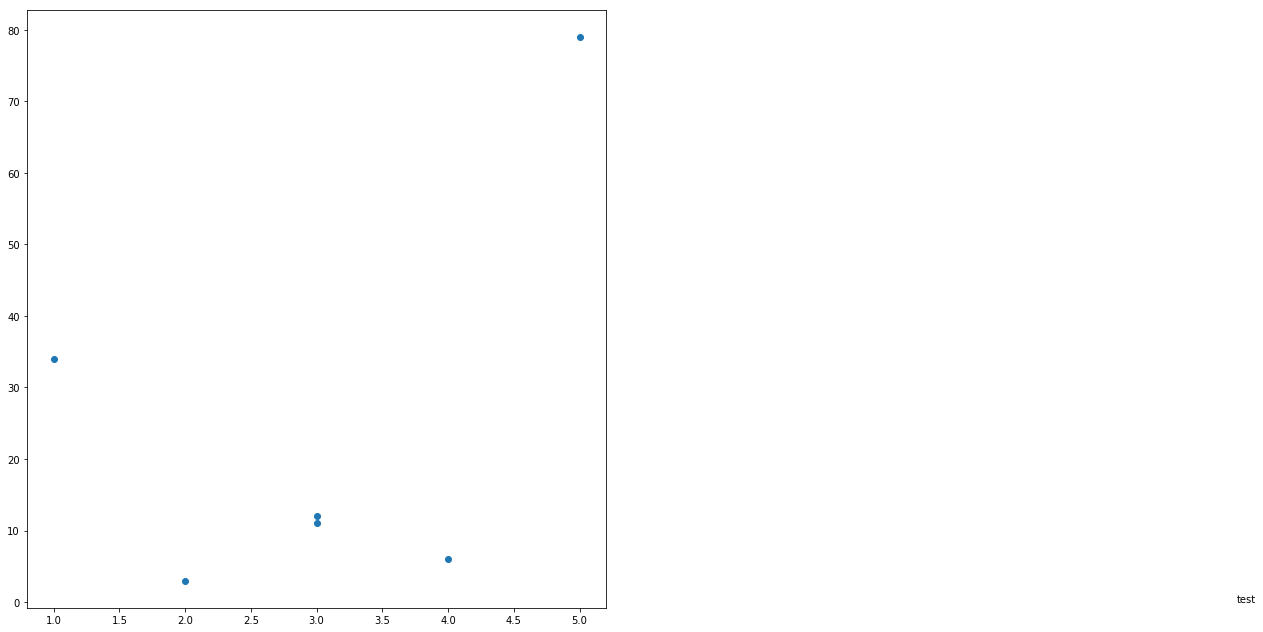

In [4]:
fig = plt.figure(figsize=(14,11))
annotation = 'test'
plt.scatter(DF['occorrenze'],DF['tempi'])
plt.text(10, 0, annotation, withdash=False,fontsize=10)
plt.subplots_adjust(right=0.7)
plt.savefig('testbb.jpg', bbox_inches='tight')
plt.show()

In [40]:
data = {'nomi':['A','B','A','A','C','B','E','B'], 'tempi':[0,1,2,3,4,5,6,7]}
DF =  pd.DataFrame.from_dict(data)

In [41]:
for i in DF['nomi'].unique():
    print i

A
B
C
E


In [51]:
a = DF.loc[DF['nomi'] == 'A']
#due modi per fare la differenza fra i timestamp
display(a.head(1)['tempi'].values[0] - a.tail(1)['tempi'].values[0])
display(a['tempi'].values[0] - a['tempi'].values[len(a['tempi'])-1])

lista_nomi = []
lista_dt = []

for i in DF['nomi'].unique():
    #creazione di dataframes contenenti nomi di un solo tipo
    a = DF.loc[DF['nomi'] == i]
    #differenza l'ultimo tempo ed il primo
    #display(a['tempi'].values[len(a['tempi'])-1] - a['tempi'].values[0])
    lista_nomi.append(a['nomi'].values[0])
    lista_dt.append(a['tempi'].values[len(a['tempi'])-1] - a['tempi'].values[0])

dizionario = {'nomi':lista_nomi, 'delta_t':lista_dt}

DF_1 = pd.DataFrame.from_dict(dizionario)

display(DF_1)

-3

-3

,delta_t,nomi
0,3,A
1,6,B
2,0,C
3,0,E


# TEST ON LOG DF

### -------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
def msg_to_df(file_path):
    """
    Import msgpack as pandas DF
    """
    storm_df = pd.read_msgpack(file_path)
    return storm_df

In [6]:
def most_frequent(storm_df, label):
    val_freq_df = storm_df[label].value_counts().to_frame()
    val_freq_df = pd.DataFrame({label : list(val_freq_df.index), 'OCCURENCIES' : list(val_freq_df.values)},columns=[label,'OCCURENCIES'])
    
    #check for missing value:
    if (reduce(lambda x, y: x+y, val_freq_df['OCCURENCIES']) != len(storm_df[label])):
        print "SOMETHING GONE WRONG" 
        
    return val_freq_df

In [7]:
test_df = msg_to_df('storm-frontend-server.log-20180901.msg')

In [48]:
def alternative(df):
    """
    deprecated
    """
    df=df[['TOKEN','TIMESTAMP']]
    lista1=[]
    lista2=[]
    for token in df['TOKEN'].unique():
        df1 = df.where(df == token)
        df2 = df.loc[df1['TOKEN'] == token]
        lista1.append(token)
        lista2.append(df2.tail(1)['TIMESTAMP'].values[0] - df2.head(1)['TIMESTAMP'].values[0])
    dizionario = {'TOKEN':lista1,'delta_t':lista2}
    DF3= pd.DataFrame.from_dict(dizionario)
    return DF3

In [8]:
def alternative1(df):
    """
    create for each unique token a df containing all the rows related to that token,
    then uses timestamp of last and first row to find token duration. 
    """
    
    lista1=[]
    lista2=[]
    for token in df['TOKEN'].unique():
        if token != '?':
            df2 = df.loc[df.TOKEN == token]
            lista1.append(token)
            lista2.append(df2.tail(1)['TIMESTAMP'].values[0] - df2.head(1)['TIMESTAMP'].values[0])
    dizionario = {'TOKEN':lista1,'DELTA_T':lista2}
    DF3= pd.DataFrame.from_dict(dizionario)
    return DF3

In [12]:
def alternative2(df):
    """
    as alternative1, use np function where to find out index of uniques token, the with index 
    """
    lista1 , lista2 = [], []
    for token in df.TOKEN.unique():
        lista1.append(token)
        index = np.where(df.TOKEN == token)
        lista2.append(df['TIMESTAMP'].values[index[0][-1]] - df['TIMESTAMP'].values[index[0][0]])
    dizionario ={'TOKEN':lista1, 'DELTA_T':lista2}
    return pd.DataFrame.from_dict(dizionario)

        

In [6]:
def alternative3(df):
    """
    incomplete
    """
    df_mf = most_frequent(df,'TOKEN')
    df =pd.merge(df,df_mf)
    df =df.loc[df.OCCURENCIES > 1]
    return df

In [108]:
index = np.where(test_df.TOKEN == '8728bd92-e1a4-472f-8c61-5630a1800cfc')
print index[0][0]

1


IDEA: forse si può velocizzare il processo scartando tutti i token che compaiono una sola volta e che sono subito disponibili utilizando most_frequent <br>
IDEA: se  partisse dall'inizio a cercarmi i valori da confrontare (token) ed una volta trovato il primo partisse dalla fine del dataframe noi potremmo evitare di parsare tutti quelli in mezzo. La sequenza sarebbe find first, .iloc[::-1] e di nuovo find first<br>
IDEA: Chunkare, faccio l'elaborazione di 100000 in 100000, trovo il modo di confrontare  i token  dei vari chunck e capire se nel loro delta_t deve essere aggiunto qualcosa ( un modo potrebbe essere salvare t iniziale e t finale dei token, se il t finale del chunck 1 corrisponde al t iniziale del chuck 2 ma non al t finale allora bisogna sommare il delta_t) Forse è persino più facile di così.

In [19]:
def merge_w_occ(storm_df,H=1000):
    df1 = alternative1(storm_df.head(H))
    df2 = most_frequent(storm_df.head(H), 'TOKEN')
    final = pd.merge(df1,df2, on='TOKEN')
    #final = final['TOKEN','DELTA_T','OCCURENCIES']
    return final
    

In [9]:
def merge_w_occ1(storm_df):
    df1 = alternative1(storm_df)
    df2 = most_frequent(storm_df, 'TOKEN')
    final = pd.merge(df1,df2, on='TOKEN')
    #final = final['TOKEN','DELTA_T','OCCURENCIES']
    return final
    

In [41]:
def scatterer(scatter_df):
    fig = plt.figure(figsize=(14,11))
    plt.suptitle('SCATTER DI TOKEN')
    plt.scatter(scatter_df['OCCURENCIES'],scatter_df['DELTA_T'],s=2)
    #plt.text(10, 0, annotation, withdash=False,fontsize=10)
    #plt.subplots_adjust(right=0.7)
    #plt.savefig('testbb.jpg', bbox_inches='tight')
    plt.xlabel('NUMERO DI MESSAGGI ASSOCIATI AL TOKEN')
    plt.ylabel('INTERVALLO TEMPORALE DI ESISTENZA DEL TOKEN (s)')
    plt.legend(['token'],loc=2)
    plt.savefig('testbb.jpg', bbox_inches='tight',dpi=600,transparent=False)
    plt.grid()
    plt.show()

In [ ]:
%time merge_w_occ1(test_df).to_csv('iper_test.csv', index=False)

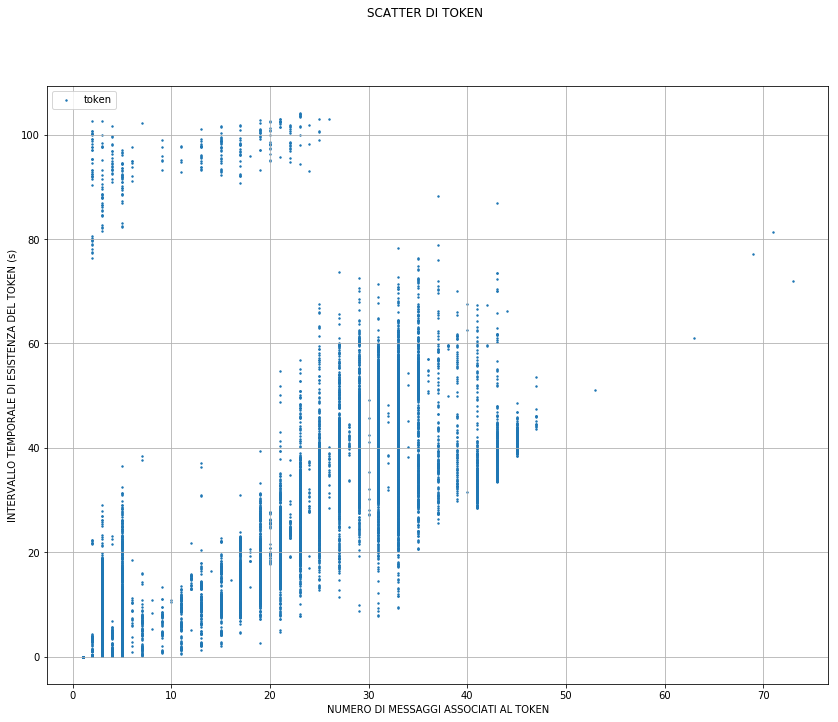

In [42]:
scatterer(scatter)

In [37]:
scatter.to_csv('scatter_storm_log_1mln.csv', index=False)

preparare un mail draft proponendo una serie di domande e di annotazioni rispetto a quello che ho visto, quello che ho fatto etc..